In [2]:
import pandas as pan
import numpy as np
import matplotlib.pyplot as plotter
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
matrix_data = pan.read_csv("rock_density_xray.csv")

In [4]:
matrix_data

,Rebound Signal Strength nHz,Rock Density kg/m3
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374
...,...,...
295,0.700227,2.112965
296,58.586585,2.000293
297,54.674548,1.879181
298,15.162434,2.644990


In [5]:
matrix_data.columns = ["Signal", "Density"]

<Axes: xlabel='Signal', ylabel='Density'>

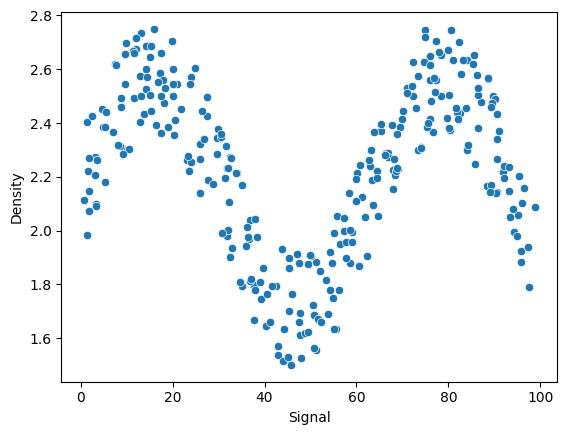

In [6]:
sns.scatterplot(x = matrix_data["Signal"], y = matrix_data["Density"])

In [7]:
feature = matrix_data["Signal"].values.reshape(-1, 1) 
label = matrix_data["Density"].values.reshape(-1, 1)

In [8]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size = 0.2, random_state = 42)

In [9]:
lin_learner = LinearRegression()
lin_learner.fit(feature_train, label_train)

LinearRegression()

In [10]:
lin_predictions = lin_learner.predict(feature_test)
print(mean_absolute_error(label_test, lin_predictions))
print(np.sqrt(mean_squared_error(label_test, lin_predictions)))

0.27312246374763055
0.32692638227151877


In [11]:
sig_range = np.arange(0, 100)
sig_pred = lin_learner.predict(sig_range.reshape(-1, 1))

<Axes: xlabel='Signal', ylabel='Density'>

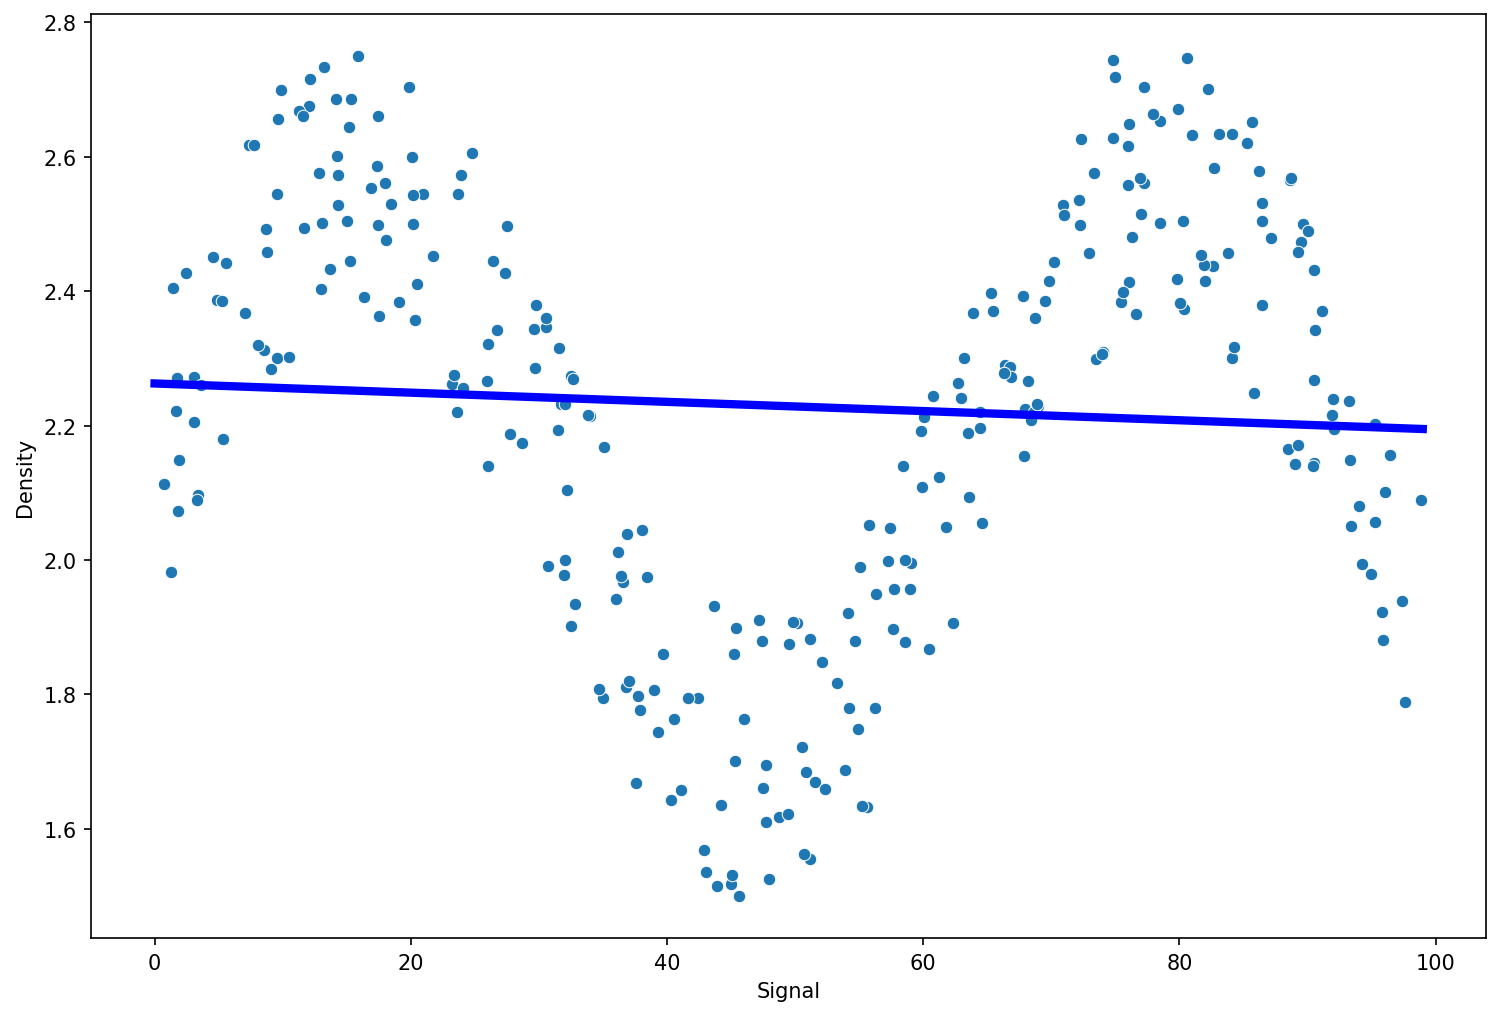

In [12]:
plotter.figure(figsize = (12, 8), dpi = 150)
plotter.plot(sig_pred, color = "blue", lw = 4)
sns.scatterplot(x = matrix_data["Signal"], y = matrix_data["Density"])

In [13]:
poly_fitter = PolynomialFeatures(include_bias = False)
order_of_operations = [("poly_fit", poly_fitter), ("lin_reg_learner", LinearRegression())]
param_grid = {"poly_fit__degree": list(range(2, 11))}
pipeline = Pipeline(order_of_operations)
test_gridder = GridSearchCV(pipeline, param_grid, scoring = "neg_mean_absolute_error", verbose = 1, cv = 5)


In [14]:
def run_model(estimator, test_features):
    estimator.fit(feature_train, label_train)
    predictions = estimator.predict(test_features)
    rmse = np.sqrt(mean_squared_error(label_test, predictions))
    estimator_pred = estimator.predict(np.arange(0, 100).reshape(-1, 1))
    plotter.plot(estimator_pred, color = "blue", lw = 4)
    sns.scatterplot(x = matrix_data["Signal"], y = matrix_data["Density"])
    return rmse

Fitting 5 folds for each of 9 candidates, totalling 45 fits


0.1361391885778878

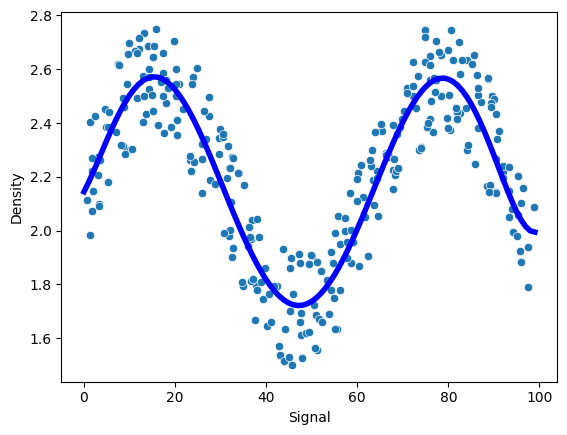

In [15]:
run_model(test_gridder, feature_test)

In [16]:
test_gridder.best_params_

{'poly_fit__degree': 6}

In [17]:
order_of_operations_two = [("scaler", StandardScaler()), ("neighbors", KNeighborsRegressor())]
pipeline_two = Pipeline(order_of_operations_two)
param_grid = {"neighbors__n_neighbors": list(range(1, 21))}
test_gridder_two = GridSearchCV(pipeline_two, param_grid, cv = 7, verbose = 1, n_jobs = 3, scoring = "neg_mean_squared_error")

Fitting 7 folds for each of 20 candidates, totalling 140 fits


0.14271446487420675

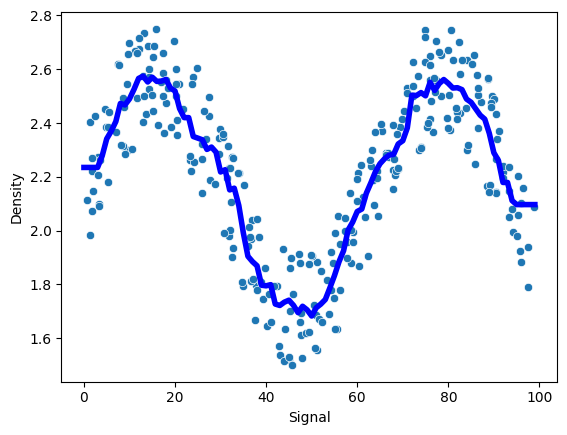

In [18]:
run_model(test_gridder_two, feature_test)

In [19]:
sub_gridder = DecisionTreeRegressor()
param_grid = {"criterion": ["squared_error", "absolute_error"], "splitter": ["random", "best"], "max_features": ["sqrt", "log2"], "max_depth": list(range(1, 9))}
test_gridder_three = GridSearchCV(sub_gridder, param_grid, verbose = 1, cv = 5, n_jobs = 3, scoring = "neg_mean_absolute_error")

Fitting 5 folds for each of 64 candidates, totalling 320 fits


0.15285453236825244

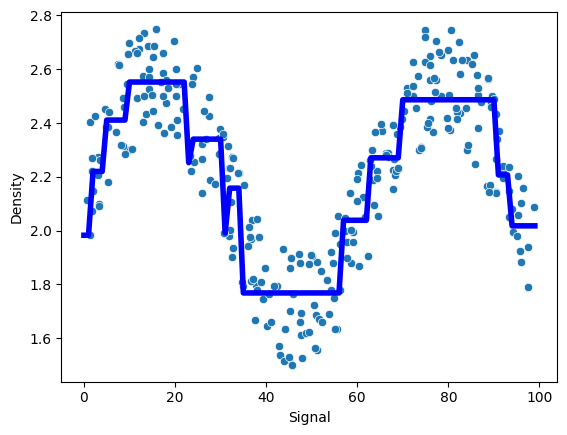

In [20]:
run_model(test_gridder_three, feature_test)

In [21]:
sv_learner = SVR()
# param_grid = {"C": [0.05, 0.1, 1, 2, 10, 100, 1000], "gamma": ["scale", "auto"], "kernel": ["rbf", "linear", "poly"], "degree": [1, 2, 3] }
param_grid = {"C": [0.05, 0.1, 1, 10, 100, 1000], "gamma": ["scale", "auto"]}
test_gridder_three = GridSearchCV(sv_learner, param_grid, cv = 5, verbose = 1, n_jobs = 3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\omoke\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13672257378472114

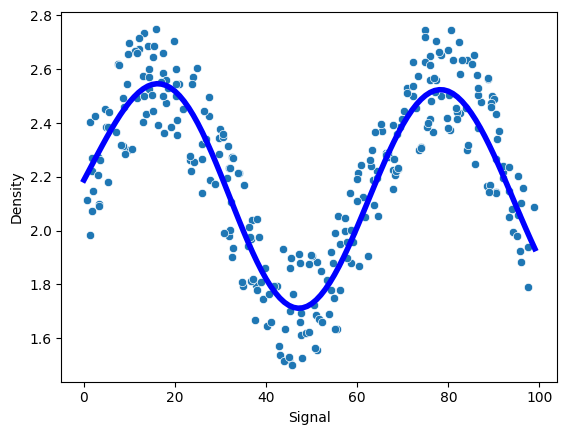

In [22]:
run_model(test_gridder_three, feature_test)

In [23]:
rf_learner = RandomForestRegressor()
param_grid = {"n_estimators": [1, 10, 100], "bootstrap": [True, False]}
last_gridder = GridSearchCV(rf_learner, param_grid, verbose = 1, cv = 5, n_jobs = -1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\omoke\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.15289012510400077

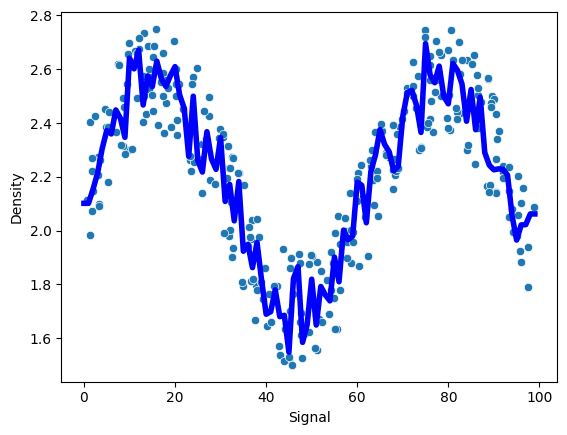

In [25]:
run_model(last_gridder, feature_test)